In [1]:
#libraries
import os
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch
from torchvision.models import vgg19, VGG19_Weights
import tensorflow as tf
from tensorflow.keras import layers, Model
from torch.cuda.amp import autocast, GradScaler
from google.colab import drive
import zipfile
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import gc







In [3]:
#extracting data from zip file

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Wider-Face/train/sharp/CelebA.zip'
extracted_path = '/content/data/CelebA'
os.makedirs(extracted_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f"Extracted files to: {extracted_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted files to: /content/data/CelebA


In [4]:
import torch
#checking the availablility of cuda

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [21]:


#Data class
class PairedSRDataset(Dataset):
    def __init__(self, root_dir, lr_folder='blur', hr_folder='sharp', lr_size=64):
        '''
        Args:
            root_dir: Root directory containing 'blur' and 'sharp' subfolders
            lr_folder: Subfolder with Low-Resolution (LR) images
            hr_folder: Subfolder with High-Resolution (HR) images
            lr_size: Size to resize LR images (HR will be resized to 4x)
        '''
        self.lr_size = lr_size
        self.hr_size = lr_size * 4  # 4× upscale
        # get
        lr_files = sorted(glob(os.path.join(root_dir, lr_folder, '*')))
        hr_files = sorted(glob(os.path.join(root_dir, hr_folder, '*')))

        # Create a dictionary of HR files for quick lookup by base name
        hr_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in hr_files}

        self.lr_paths = []
        self.hr_paths = []

        # Find matching LR and HR files based on base name
        # As now training the data on some percentage of whole dataset, so compare all the files
        # based on name so pair would be completed
        for lr_path in lr_files:
            lr_base_name = os.path.splitext(os.path.basename(lr_path))[0]
            if lr_base_name in hr_dict:
                self.lr_paths.append(lr_path)
                self.hr_paths.append(hr_dict[lr_base_name])

        print(f"Found {len(self.lr_paths)} paired images.")

        #transformation, doing normalization cos some time model train better when centered around zero
        self.transform_lr = Compose([Resize((self.lr_size, self.lr_size)), ToTensor(), Normalize((0.5,)*3, (0.5,)*3)])
        self.transform_hr = Compose([Resize((self.hr_size, self.hr_size)), ToTensor(), Normalize((0.5,)*3, (0.5,)*3)])

     # to get length
    def __len__(self):
        return len(self.lr_paths)

    def __getitem__(self, idx):
        lr = Image.open(self.lr_paths[idx]).convert('RGB')
        hr = Image.open(self.hr_paths[idx]).convert('RGB')

        return self.transform_lr(lr), self.transform_hr(hr)



# Example: load training set
train_ds = PairedSRDataset('/content/data/CelebA/CelebA/train')

# Create subset of first 5k images
subset_size = min(5000, len(train_ds))
train_subset = Subset(train_ds, indices=range(subset_size))

#Data loader
train_loader = DataLoader(
    train_subset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

Found 200000 paired images.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


5000


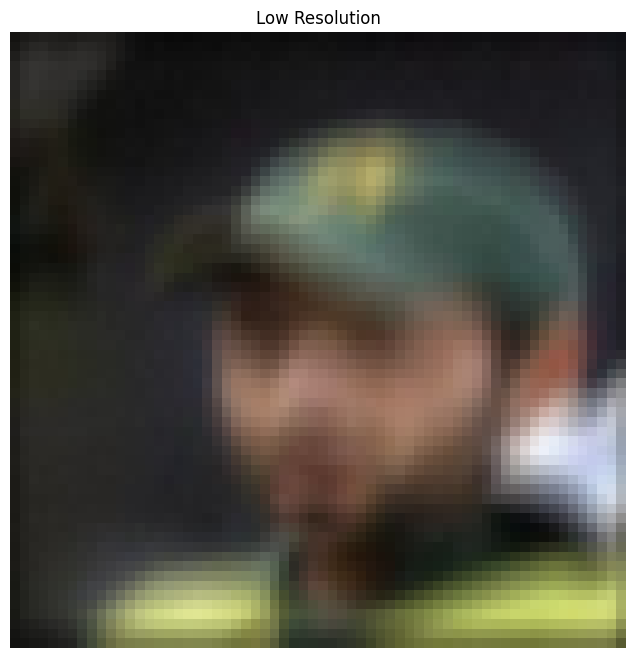

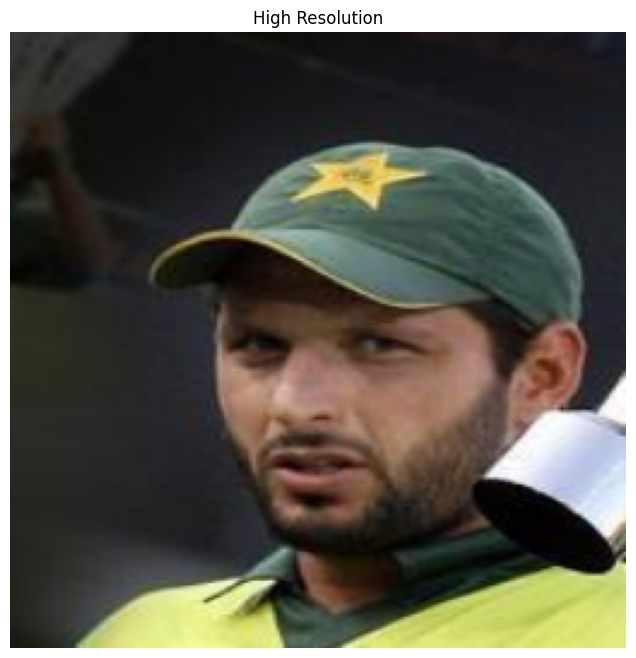

In [22]:
#printing image as a sample
print(len(train_subset))
#show image

lr, hr = train_subset[0]  # Low-res and high-res tensors

# Convert tensors back to images
lr_img = TF.to_pil_image((lr * 0.5 + 0.5))  # De-normalize
hr_img = TF.to_pil_image((hr * 0.5 + 0.5))  # De-normalize

# Plot the images
plt.figure(figsize=(12, 8))

plt.title("Low Resolution")
plt.imshow(lr_img)
plt.axis("off")
plt.show()
plt.figure(figsize=(12, 8))
plt.title("High Resolution")
plt.imshow(hr_img)
plt.axis("off")

plt.show()


In [23]:
# Generator network based on Residual-in-Residual Dense Blocks (RRDB)
# This architecture is used for super-resolution (e.g., ESRGAN)
# Structure of the model is described in ReadMe file

# Single Residual Dense Block: combines dense connections with residual scaling
# Genarator tries to Generate the real image, While discriminator act as a judge to
# distinguish between real and fake image

class ResidualDenseBlock(nn.Module):
    def __init__(self, num_feat=64, num_grow_ch=32):
        super().__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # 1 padding to ensure same output size as input
        # 1 stride, better to get spatial info
        # 3x3 kernel is normal to extract features
        # First convolution: input channels -> growth channels
        self.conv1 = nn.Conv2d(num_feat, num_grow_ch, 3, 1, 1)
        # Subsequent convolutions: input channels grow due to concatenation
        self.conv2 = nn.Conv2d(num_feat + num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv3 = nn.Conv2d(num_feat + 2 * num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv4 = nn.Conv2d(num_feat + 3 * num_grow_ch, num_grow_ch, 3, 1, 1)
        # Last convolution reduces back to original feature size
        self.conv5 = nn.Conv2d(num_feat + 4 * num_grow_ch, num_feat, 3, 1, 1)
        # Non-linearity
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        # First layer
        x1 = self.lrelu(self.conv1(x))
        # Concatenate previous outputs and input, then convolve
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        # Final convolution after dense connections
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        # Residual scaling (0.2) and skip connection
        return x5 * 0.2 + x



# Residual-in-Residual Dense Block: stacks 3 ResidualDenseBlocks with outer residual

class RRDB(nn.Module):
    def __init__(self, num_feat=64, num_grow_ch=32):
        super().__init__()
        # Stack 3 ResidualDenseBlocks
        self.rdb1 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb2 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb3 = ResidualDenseBlock(num_feat, num_grow_ch)

    def forward(self, x):
        # Sequentially pass through each RDB
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        # Outer residual connection with scaling
        return out * 0.2 + x



# Full RRDBNet: backbone for super-resolution generator

class RRDBNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, num_feat=64, num_block=23, num_grow_ch=32):
        super().__init__()
        # Initial feature extraction

        self.conv_first = nn.Conv2d(in_ch, num_feat, 3, 1, 1)

        # Body: sequence of RRDB blocks
        self.body = nn.Sequential(*[RRDB(num_feat, num_grow_ch) for _ in range(num_block)])

        # Convolution after the RRDB body
        self.conv_body = nn.Conv2d(num_feat, num_feat, 3, 1, 1)

        # Upsampling layers: two upsampling stages (scale ×4)
        self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)

        # Final convolutions to produce high-resolution output
        self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_last = nn.Conv2d(num_feat, out_ch, 3, 1, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        # Extract initial features
        feat = self.conv_first(x)

        # Process through RRDB blocks and add skip connection
        body_feat = self.conv_body(self.body(feat))
        feat = feat + body_feat

        # First upsampling by factor 2
        feat = self.lrelu(self.conv_up1(F.interpolate(feat, scale_factor=2, mode='nearest')))

        # Second upsampling by factor 2 (total ×4)
        feat = self.lrelu(self.conv_up2(F.interpolate(feat, scale_factor=2, mode='nearest')))

        # Final convolutions to produce output image
        feat = self.conv_hr(feat)
        out = self.conv_last(feat)
        return torch.tanh(out)



In [24]:
#Discriminator
# will try to judge the real and fake image, in our case the dataset HR image
# is considered as the real while the image generated by Generator is considered as fake image
# will extract the features, first basic texture then deep features and then convert into 1D to
# compare both images
class VGGStyleDiscriminator(nn.Module):
    def __init__(self, in_ch=3, num_feat=64):
        super().__init__()
        self.conv0_0 = nn.Conv2d(in_ch, num_feat, 3, 1, 1)
        self.conv0_1 = nn.Conv2d(num_feat, num_feat, 4, 2, 1, bias=False)
        self.lrelu = nn.LeakyReLU(0.2, True)

        # Downsampling blocks
        self.conv1_0 = nn.Conv2d(num_feat, num_feat * 2, 3, 1, 1, bias=False)
        self.conv1_1 = nn.Conv2d(num_feat * 2, num_feat * 2, 4, 2, 1, bias=False) #downsampling

        self.conv2_0 = nn.Conv2d(num_feat * 2, num_feat * 4, 3, 1, 1, bias=False)
        self.conv2_1 = nn.Conv2d(num_feat * 4, num_feat * 4, 4, 2, 1, bias=False) #downsampling

        self.conv3_0 = nn.Conv2d(num_feat * 4, num_feat * 8, 3, 1, 1, bias=False)
        self.conv3_1 = nn.Conv2d(num_feat * 8, num_feat * 8, 4, 2, 1, bias=False)#downsamplinf

        # Final layers
        self.conv4 = nn.Conv2d(num_feat * 8, 1, 3, 1, 1)

    def forward(self, x):
      #normal CNN- LAyers
        x = self.lrelu(self.conv0_0(x))
        x = self.lrelu(self.conv0_1(x))
        x = self.lrelu(self.conv1_0(x))
        x = self.lrelu(self.conv1_1(x))
        x = self.lrelu(self.conv2_0(x))
        x = self.lrelu(self.conv2_1(x))
        x = self.lrelu(self.conv3_0(x))
        x = self.lrelu(self.conv3_1(x))
        x = self.conv4(x)
        return x


In [25]:


# Loss Functions, perceptual loss
class PerceptualLoss(nn.Module):
  #compare feature extracted from image using pretrained VGG
  #after normalizing the input as the model expected
    def __init__(self):
        super().__init__()
        vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features[:35].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.criterion = nn.L1Loss()
        # These are the standard ImageNet normalization values
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

    def forward(self, fake, real):
        # First, un-normalize from [-1, 1] to [0, 1]
        fake_0_1 = (fake + 1.0) / 2.0
        real_0_1 = (real + 1.0) / 2.0

        # Now, apply the VGG's expected normalization (from [0, 1] range)
        fake_normalized = (fake_0_1 - self.mean.to(fake.device)) / self.std.to(fake.device)
        real_normalized = (real_0_1 - self.mean.to(real.device)) / self.std.to(real.device)

        features_fake = self.vgg(fake_normalized)
        features_real = self.vgg(real_normalized)
        return self.criterion(features_fake, features_real)
# Relativistic average Discriminator Loss
class RelativisticDiscriminatorLoss(nn.Module):
  # here discriminator compare the images relatively rather then separetly
  # which help the discriminator to be overconfident

    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred_real, pred_fake):
        real_logit = pred_real - torch.mean(pred_fake)
        fake_logit = pred_fake - torch.mean(pred_real)
        return self.bce(real_logit, torch.ones_like(real_logit)) + \
               self.bce(fake_logit, torch.zeros_like(fake_logit))

# Relativistic average Generator Loss
class RelativisticGeneratorLoss(nn.Module):
  # same like in discrminator, help the generator to increase the relative realism
  # of fake image compare to real one, use in Combined generator loss
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred_real, pred_fake):

        real_logit = pred_real - torch.mean(pred_fake)
        fake_logit = pred_fake - torch.mean(pred_real)
        return self.bce(real_logit, torch.zeros_like(real_logit)) + \
               self.bce(fake_logit, torch.ones_like(fake_logit))

class CombinedGeneratorLoss(nn.Module):
  # combine realism, perceptual and l1 loss (to preserve structure and color)
    def __init__(self, w_adv=0.005, w_perceptual=1.0, w_l1=0.01):
        super().__init__()
        self.w_adv = w_adv
        self.w_perceptual = w_perceptual
        self.w_l1 = w_l1
        self.perceptual = PerceptualLoss()
        self.adversarial = RelativisticGeneratorLoss()
        self.l1 = nn.L1Loss()

    def forward(self, fake_hr, real_hr, pred_fake, pred_real):
        adv_loss = self.adversarial(pred_real, pred_fake)
        perceptual_loss = self.perceptual(fake_hr, real_hr)
        l1_loss = self.l1(fake_hr, real_hr)

        return (self.w_adv * adv_loss +
                self.w_perceptual * perceptual_loss +
                self.w_l1 * l1_loss)


In [26]:

# Training part
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize models
generator = RRDBNet(in_ch=3, out_ch=3, num_feat=64, num_block=23, num_grow_ch=32).to(device)
discriminator = VGGStyleDiscriminator(in_ch=3, num_feat=64).to(device)

# Load pretrained generator weights
weights_path = "/content/drive/MyDrive/RealESRGAN_x4.pth"
state_dict = torch.load(weights_path)

# pretrained weight of esrgan
if 'params_ema' in state_dict:
    clean_state_dict = state_dict['params_ema']
elif 'params' in state_dict:
    clean_state_dict = state_dict['params']
else:
    clean_state_dict = state_dict

generator.load_state_dict(clean_state_dict, strict=True)
print("Loaded")


# Freeze all parameters in the generator
for param in generator.parameters():
    param.requires_grad = False

#  Unfreeze only the desired layers for fine-tuning
for name, param in generator.named_parameters():
    if 'conv_last' in name:
        param.requires_grad = True
        print(f"Unfrozen for training: {name}")

# optimizer
opt_g = optim.Adam(
    filter(lambda p: p.requires_grad, generator.parameters()),
    lr=1e-5,  # Use a smaller learning rate for fine-tuning
    betas=(0.9, 0.999)
)
# The discriminator will be trained from scratch
opt_d = optim.Adam(discriminator.parameters(), lr=2e-5, betas=(0.9, 0.999))

#  Initialize Loss Functions
g_loss_fn = CombinedGeneratorLoss().to(device)
d_loss_fn = RelativisticDiscriminatorLoss().to(device)





Using device: cuda
Loaded
Unfrozen for training: conv_last.weight
Unfrozen for training: conv_last.bias


In [29]:
# Training LOop
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import torch
import gc

# Initialize AMP GradScalers for performance
# also to upscale the loss before backpropagation
# to overcome underflow issue
# Initialize scalers with the new syntax
d_scaler = GradScaler()
g_scaler = GradScaler()

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    generator.train()
    discriminator.train()

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for batch_idx, (lr_imgs, hr_imgs) in progress_bar:
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)


        # Train Discriminator
        # clear previoulsy stored gradient
        opt_d.zero_grad()

        with autocast(device_type='cuda', dtype=torch.float16): # use float 16 to speed up the traininf
            with torch.no_grad(): # prevent generator to update diring the training of D
                fake_hr = generator(lr_imgs) # Genrate the image from generator

            pred_real = discriminator(hr_imgs) # generatr from the discreminator
            pred_fake = discriminator(fake_hr.detach()) #output for the imsge generated by generator
            d_loss = d_loss_fn(pred_real, pred_fake) # loss fun
        # compute gradient for the next
        d_scaler.scale(d_loss).backward()
        d_scaler.step(opt_d)
        d_scaler.update()


        #  Train Generator opposite to disciminator

        opt_g.zero_grad()

        with autocast(device_type='cuda', dtype=torch.float16):
            # Re-generate fake images to build computation graph for generator
            fake_hr = generator(lr_imgs)
            pred_fake = discriminator(fake_hr)
            pred_real = discriminator(hr_imgs).detach()

            g_loss = g_loss_fn(fake_hr, hr_imgs, pred_fake, pred_real)

        g_scaler.scale(g_loss).backward()
        g_scaler.step(opt_g)
        g_scaler.update()

        # Update progress bar
        progress_bar.set_postfix(G_Loss=f'{g_loss.item():.4f}', D_Loss=f'{d_loss.item():.4f}')

    print(f"\n End of Epoch {epoch+1}")

    # Optional: clean GPU cache
    gc.collect()
    torch.cuda.empty_cache()

    # Save checkpoint
    if (epoch + 1) % 5 == 0:
        torch.save({
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'opt_g': opt_g.state_dict(),
            'opt_d': opt_d.state_dict(),
            'epoch': epoch,
        }, f"finetuned_realesrgan_epoch_{epoch+1}.pth")
        print(f"Saved checkpoint for epoch {epoch+1}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/10: 100%|██████████| 625/625 [06:26<00:00,  1.62it/s, D_Loss=0.1030, G_Loss=3.3897]



 End of Epoch 1


Epoch 2/10: 100%|██████████| 625/625 [06:26<00:00,  1.62it/s, D_Loss=0.0155, G_Loss=3.2870]



 End of Epoch 2


Epoch 3/10: 100%|██████████| 625/625 [06:25<00:00,  1.62it/s, D_Loss=0.0419, G_Loss=3.2675]



 End of Epoch 3


Epoch 4/10: 100%|██████████| 625/625 [06:25<00:00,  1.62it/s, D_Loss=0.0294, G_Loss=3.0866]



 End of Epoch 4


Epoch 5/10: 100%|██████████| 625/625 [06:25<00:00,  1.62it/s, D_Loss=0.0154, G_Loss=2.8502]



 End of Epoch 5
Saved checkpoint for epoch 5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/10: 100%|██████████| 625/625 [06:25<00:00,  1.62it/s, D_Loss=0.0028, G_Loss=3.1317]



 End of Epoch 6


Epoch 7/10: 100%|██████████| 625/625 [06:25<00:00,  1.62it/s, D_Loss=0.0045, G_Loss=2.9148]



 End of Epoch 7


Epoch 8/10: 100%|██████████| 625/625 [06:25<00:00,  1.62it/s, D_Loss=0.0009, G_Loss=3.2532]



 End of Epoch 8


Epoch 9/10: 100%|██████████| 625/625 [06:25<00:00,  1.62it/s, D_Loss=0.0093, G_Loss=2.9508]



 End of Epoch 9


Epoch 10/10: 100%|██████████| 625/625 [06:25<00:00,  1.62it/s, D_Loss=0.0076, G_Loss=2.9112]



 End of Epoch 10
Saved checkpoint for epoch 10


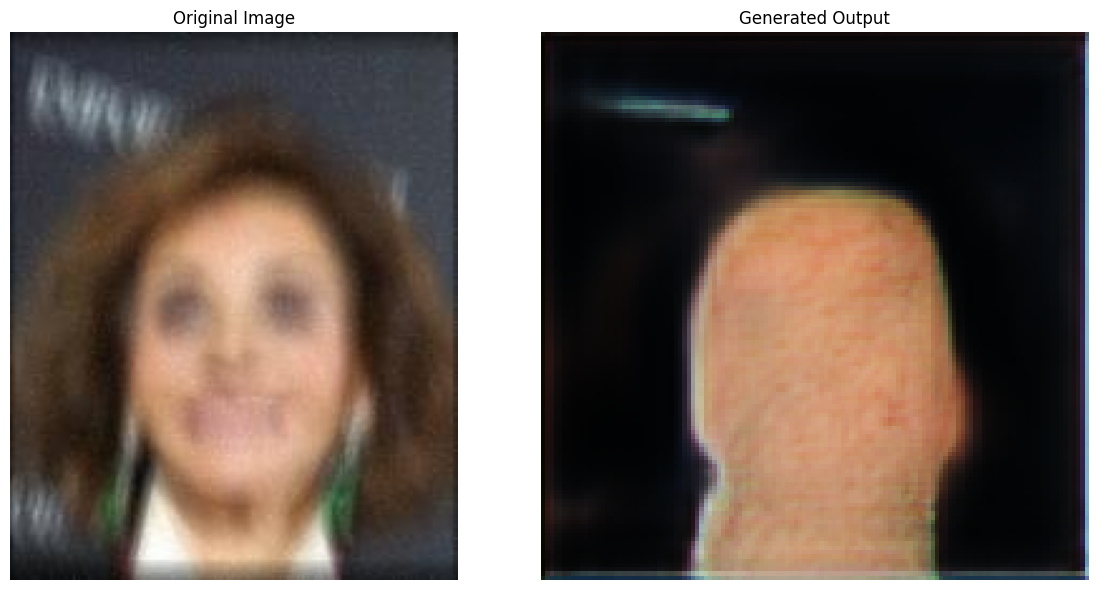

In [35]:
# testing part

import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt

# 1) Load your trained model
model = RRDBNet()
# Load the checkpoint
checkpoint = torch.load("/content/finetuned_realesrgan_epoch_10.pth", map_location="cuda")
# Load only the generator's state_dict
model.load_state_dict(checkpoint['generator'])
model.eval()
model = model.cuda()

# 2) Prepare the same transform you used during training
transform = Compose([
    Resize((32,32)),
    ToTensor(),
    Normalize((0.5,)*3, (0.5,)*3)
])

# 3) Load a test LR image
img = Image.open("/content/2.jpg").convert("RGB")
lr_tensor = transform(img).unsqueeze(0).cuda()   # shape [1,3,32,32]

# 4) Run through model
with torch.no_grad():
    output = model(lr_tensor)

# 5) Denormalize output from [-1,1] back to [0,1]
output = (output.clamp(-1,1) + 1) / 2

# 6) Convert tensor to numpy image
output_image = output.squeeze(0).permute(1,2,0).cpu().numpy()

# 7) Visualize with matplotlib

plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Output Image
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title("Generated Output")
plt.axis("off")

plt.tight_layout()
plt.show()